In [574]:
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import mne

In [575]:
# Source https://github.com/Mentalab-hub/explorepy/blob/master/examples/ssvep_demo/offline_analysis.py
def custom_filter(exg, lf, hf, fs, type):
    """
    
    Args:
        exg: EEG signal with the shape: (N_chan, N_sample)
        lf: Low cutoff frequency
        hf: High cutoff frequency
        fs: Sampling rate
        type: Filter type, 'bandstop' or 'bandpass'

    Returns:
        (numpy ndarray): Filtered signal (N_chan, N_sample)
    """
    N = 4
    b, a = signal.butter(N, [lf / (fs/2), hf / (fs/2)], type)
    return signal.filtfilt(b, a, exg)

In [576]:
# Initialization
fs = 250 #Hz
lf = 1 #Hz
hf = 30 #Hz

chan_name = ['POz', 'PO3', 'PO4', 'PO7', 'O2', 'O1', 'Oz', 'PO8']
n_chan = len(chan_name)
chan_list = ['ch' + str(i) for i in range(1, n_chan + 1)]

In [577]:
# Import data
eeg_7_5 = pd.read_csv('data/SSVEP_VR_1m/7_5_ssvep_ExG.csv')
eeg_10 = pd.read_csv('data/SSVEP_VR_1m/10_ssvep_ExG.csv')
eeg_resting = pd.read_csv('data/SSVEP_VR_1m/resting_ExG.csv')

In [578]:
sig_eeg_7_5 = eeg_7_5[chan_list].to_numpy().T
sig_eeg_10 = eeg_10[chan_list].to_numpy().T
sig_eeg_resting = eeg_resting[chan_list].to_numpy().T

In [579]:
# Signal filtering, bandpass 1-30Hz, bandstop 45-55Hz
def filt(sig,fs=250, lf=1, hf=30):
    filt_sig = custom_filter(sig, 45, 55, fs, 'bandstop') 
    filt_sig = custom_filter(filt_sig, lf, hf, fs, 'bandpass')
    return filt_sig

In [580]:
# Filter the signal
filt_sig_eeg_7_5 = filt(sig_eeg_7_5)
filt_sig_eeg_10 = filt(sig_eeg_10)
filt_sig_eeg_resting = filt(sig_eeg_resting)

In [581]:
def amplitude_plot(filt_signal, chan_name, title = '', fs=250, lim = 150,xlim=None):
    n_samples = filt_signal.shape[1]

    # Generate a time vector for the signal
    t = np.arange(n_samples) / fs

    # Create a single plot with a single subplot
    fig, ax = plt.subplots(figsize=(15, 3))

    # Loop through each signal and plot it on the same subplot
    for i in range(len(filt_signal)):
        ax.plot(t, filt_signal[i], label='{}'.format(chan_name[i]))

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_ylim(-1*lim, lim)
    if xlim:
        ax.set_xlim(0, xlim)
    ax.legend()
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


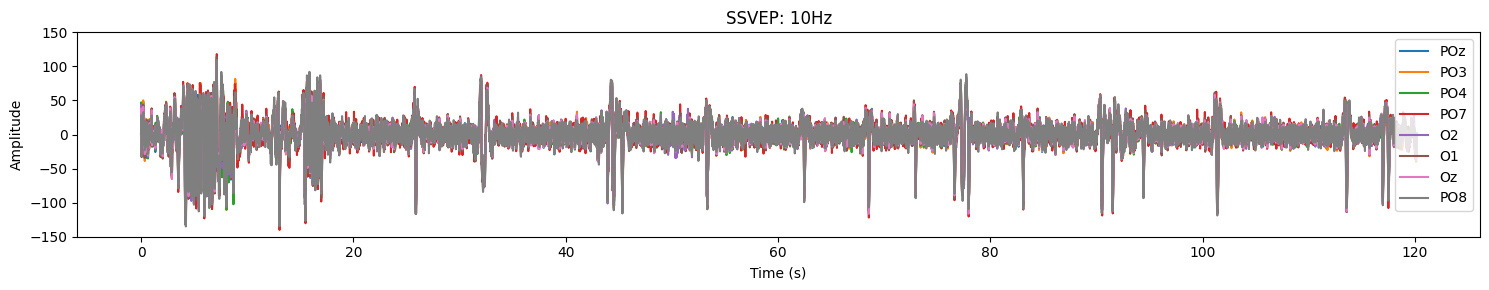

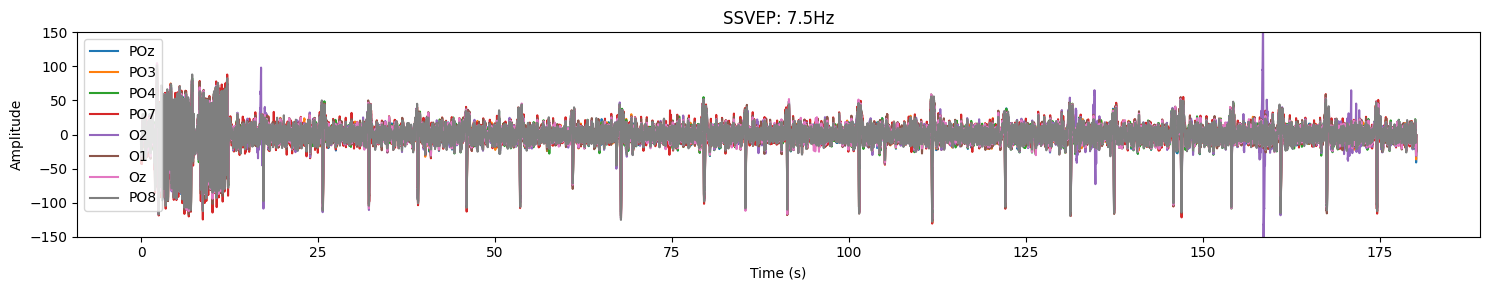

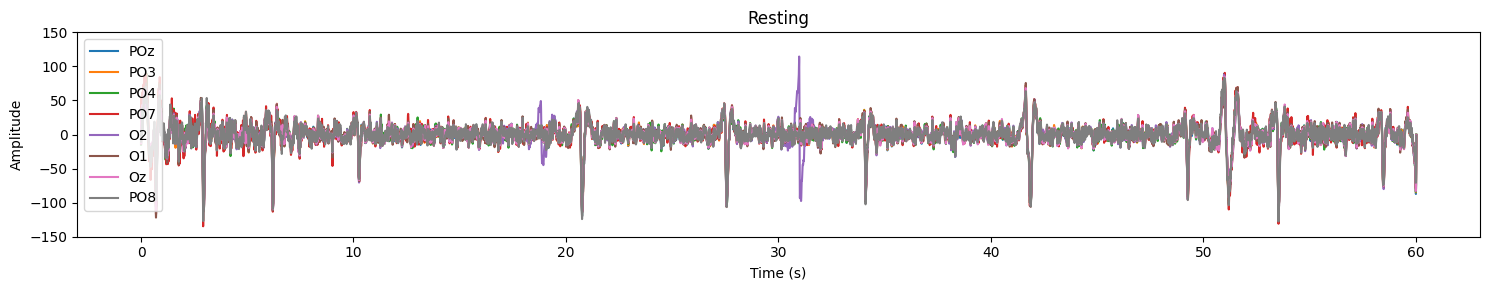

In [582]:
# Plot the signal amplitude VS time
amplitude_plot(filt_sig_eeg_10,chan_name, title = "SSVEP: 10Hz")
amplitude_plot(filt_sig_eeg_7_5,chan_name,title = 'SSVEP: 7.5Hz')
amplitude_plot(filt_sig_eeg_resting,chan_name,title = 'Resting')

In [583]:
def cut_signal(filt_signal, start, end, fs=250):
    cut_start = int(start * fs)
    cut_end = int(end * fs)
    output = []

    for i in range(0,len(filt_signal)):
        output.append(filt_signal[i][cut_start:len(filt_signal[i])-cut_end])
    return np.array(output)

In [584]:
# Cut the signal so that the first 20 seconds and the last 10 seconds are removed
filt_sig_eeg_10 = cut_signal(filt_sig_eeg_10,20,10)
filt_sig_eeg_7_5 = cut_signal(filt_sig_eeg_7_5,20,10)
filt_sig_eeg_resting = cut_signal(filt_sig_eeg_resting,20,10)

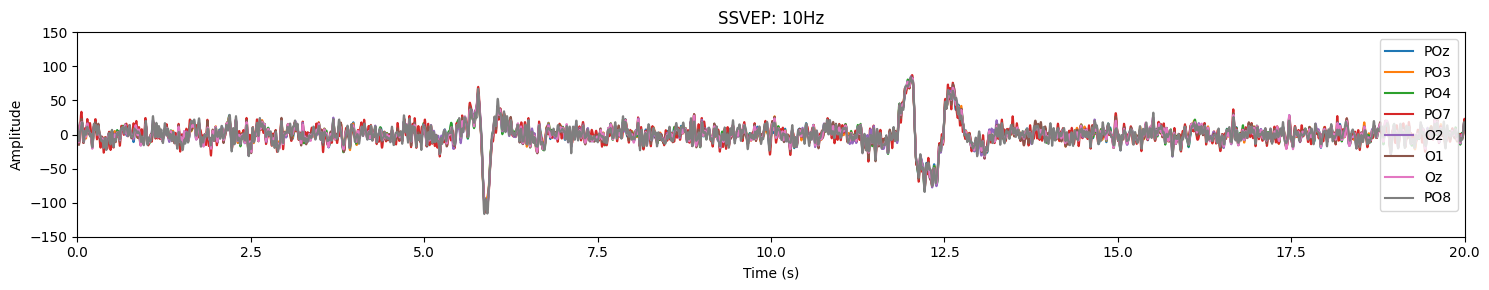

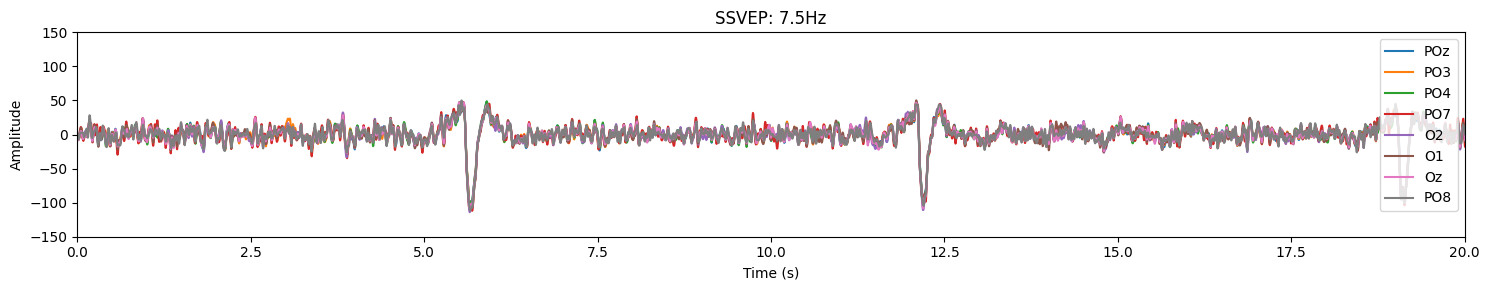

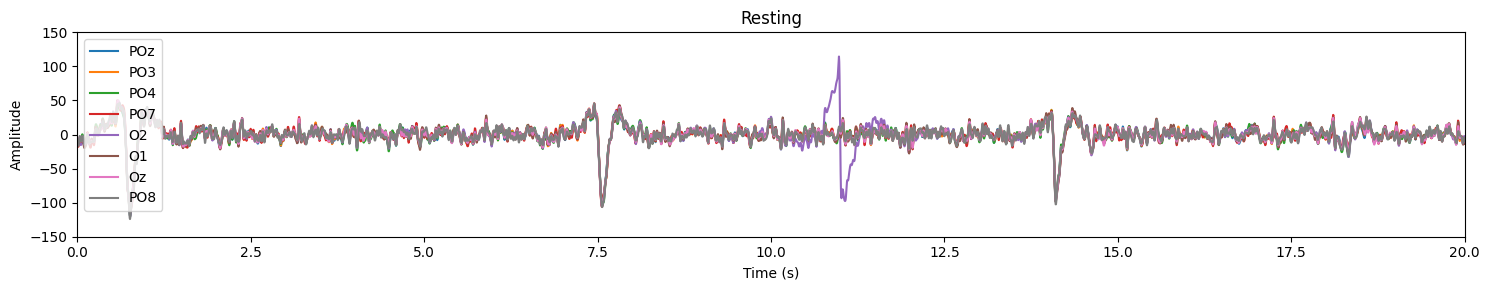

In [585]:
# The first 20 seconds of the cut signal
amplitude_plot(filt_sig_eeg_10,chan_name, title = "SSVEP: 10Hz", xlim=20)
amplitude_plot(filt_sig_eeg_7_5,chan_name,title = 'SSVEP: 7.5Hz',xlim=20)
amplitude_plot(filt_sig_eeg_resting,chan_name,title = 'Resting', xlim=20)

In [596]:
def psd_plot(filt_signal, chan_name, title='', fs=250, x_min=1, x_lim=30, y_lim = 125, line=None):
    n_samples = filt_signal.shape[1]

    # Generate a time vector for the signal
    t = np.arange(n_samples) / fs

    # Create a single plot with a single subplot
    fig, ax = plt.subplots(figsize=(15, 3))

    # Loop through each signal and plot it on the same subplot
    for i in range(len(filt_signal)):
        f, psd = signal.welch(filt_signal[i], fs=fs, nperseg=20*fs, noverlap=0, nfft=20*fs)
        ax.plot(f, psd, label='{}'.format(chan_name[i]))

    if line:
        ax.axvline(x=line, color='gray', linestyle='--')
        ax.text(line+0.2, 20, 'f = '+str(line)+'Hz', fontsize=12, color='gray')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (V^2/Hz)')
    ax.set_xlim(x_min, x_lim)
    ax.set_ylim(0, y_lim)
    ax.legend()
    ax.set_title('PSD ' + title)
    plt.tight_layout()
    plt.show()


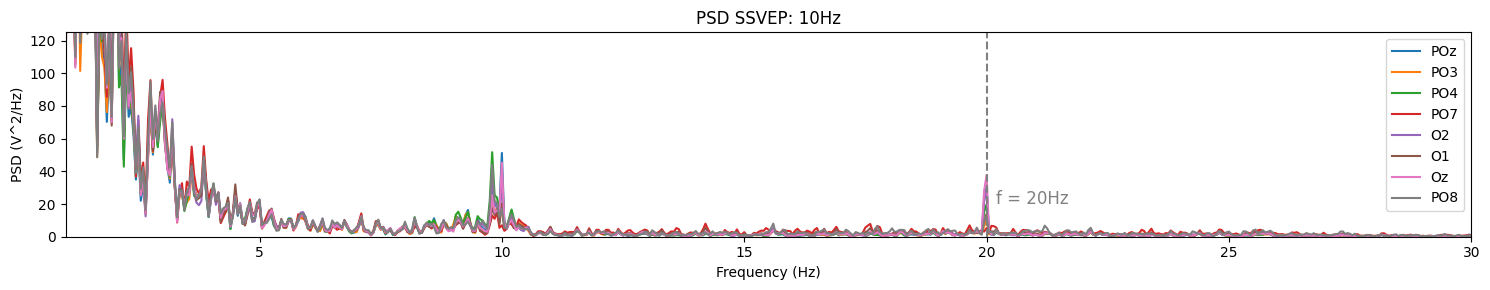

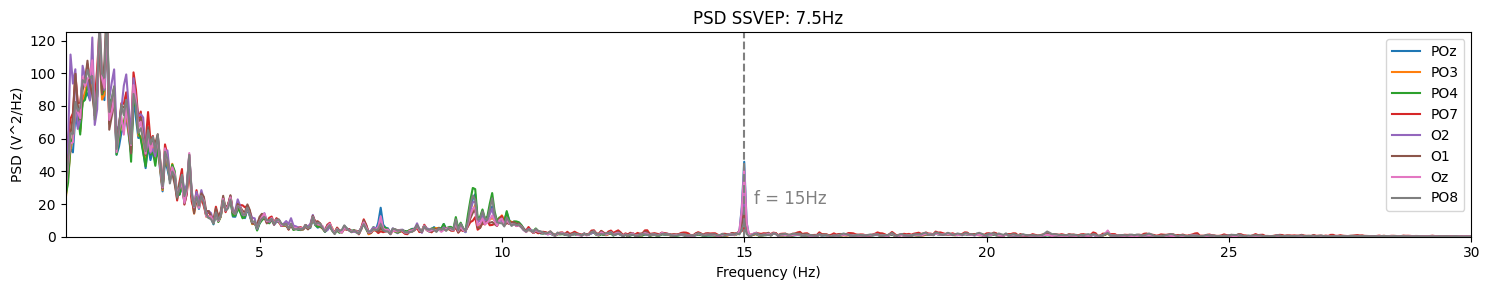

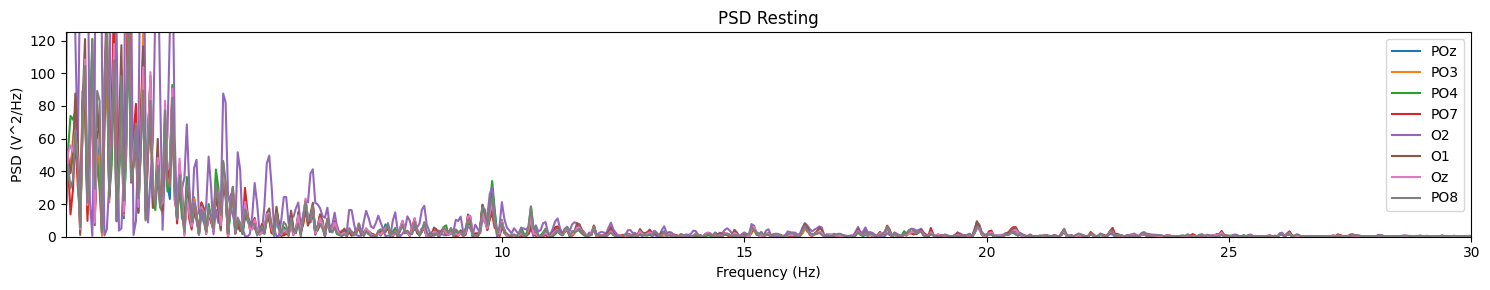

In [602]:
# Plot the signal PSD
psd_plot(filt_sig_eeg_10,chan_name, title = "SSVEP: 10Hz", line=20)
psd_plot(filt_sig_eeg_7_5,chan_name,title = 'SSVEP: 7.5Hz',line=15)
psd_plot(filt_sig_eeg_resting,chan_name,title = 'Resting')

In [588]:
def reshape_to_epochs(data, epoch_length=6, sfreq=250):
    n_channels, n_samples = data.shape
    n_epochs = int(n_samples / (epoch_length * sfreq))
    epoch_samples = epoch_length * sfreq
    epoch_data = np.zeros((n_epochs, n_channels, epoch_samples))
    
    for i in range(n_epochs):
        start = i * epoch_samples
        end = start + epoch_samples
        epoch_data[i] = data[:, start:end]
    
    return epoch_data

In [600]:
%%capture 

epochs_10 = reshape_to_epochs(filt_sig_eeg_10)
epochs_7_5 = reshape_to_epochs(filt_sig_eeg_7_5)
epochs_resting = reshape_to_epochs(filt_sig_eeg_resting)

freqs = np.arange(10., 30., .3)
n_cycles = freqs
t_min, t_max = 1, 6

class_names = ['10Hz', '7.5Hz', 'Resting']

times = np.linspace(t_min, t_max, epochs_10.shape[2])

power_10 = mne.time_frequency.tfr_array_morlet(epochs_10, sfreq=fs, freqs=freqs, n_cycles=n_cycles, output='avg_power')
power_7_5 = mne.time_frequency.tfr_array_morlet(epochs_7_5, sfreq=fs, freqs=freqs, n_cycles=n_cycles, output='avg_power')
power_rest = mne.time_frequency.tfr_array_morlet(epochs_resting, sfreq=fs, freqs=freqs, n_cycles=n_cycles, output='avg_power')

power = np.stack([power_10 , power_7_5, power_rest])

mne.baseline.rescale(power_10, times, (None, times[0]), mode='mean', copy=False)
mne.baseline.rescale(power_7_5, times, (None, times[0]), mode='mean', copy=False)
mne.baseline.rescale(power_rest, times, (None, times[0]), mode='mean', copy=False)

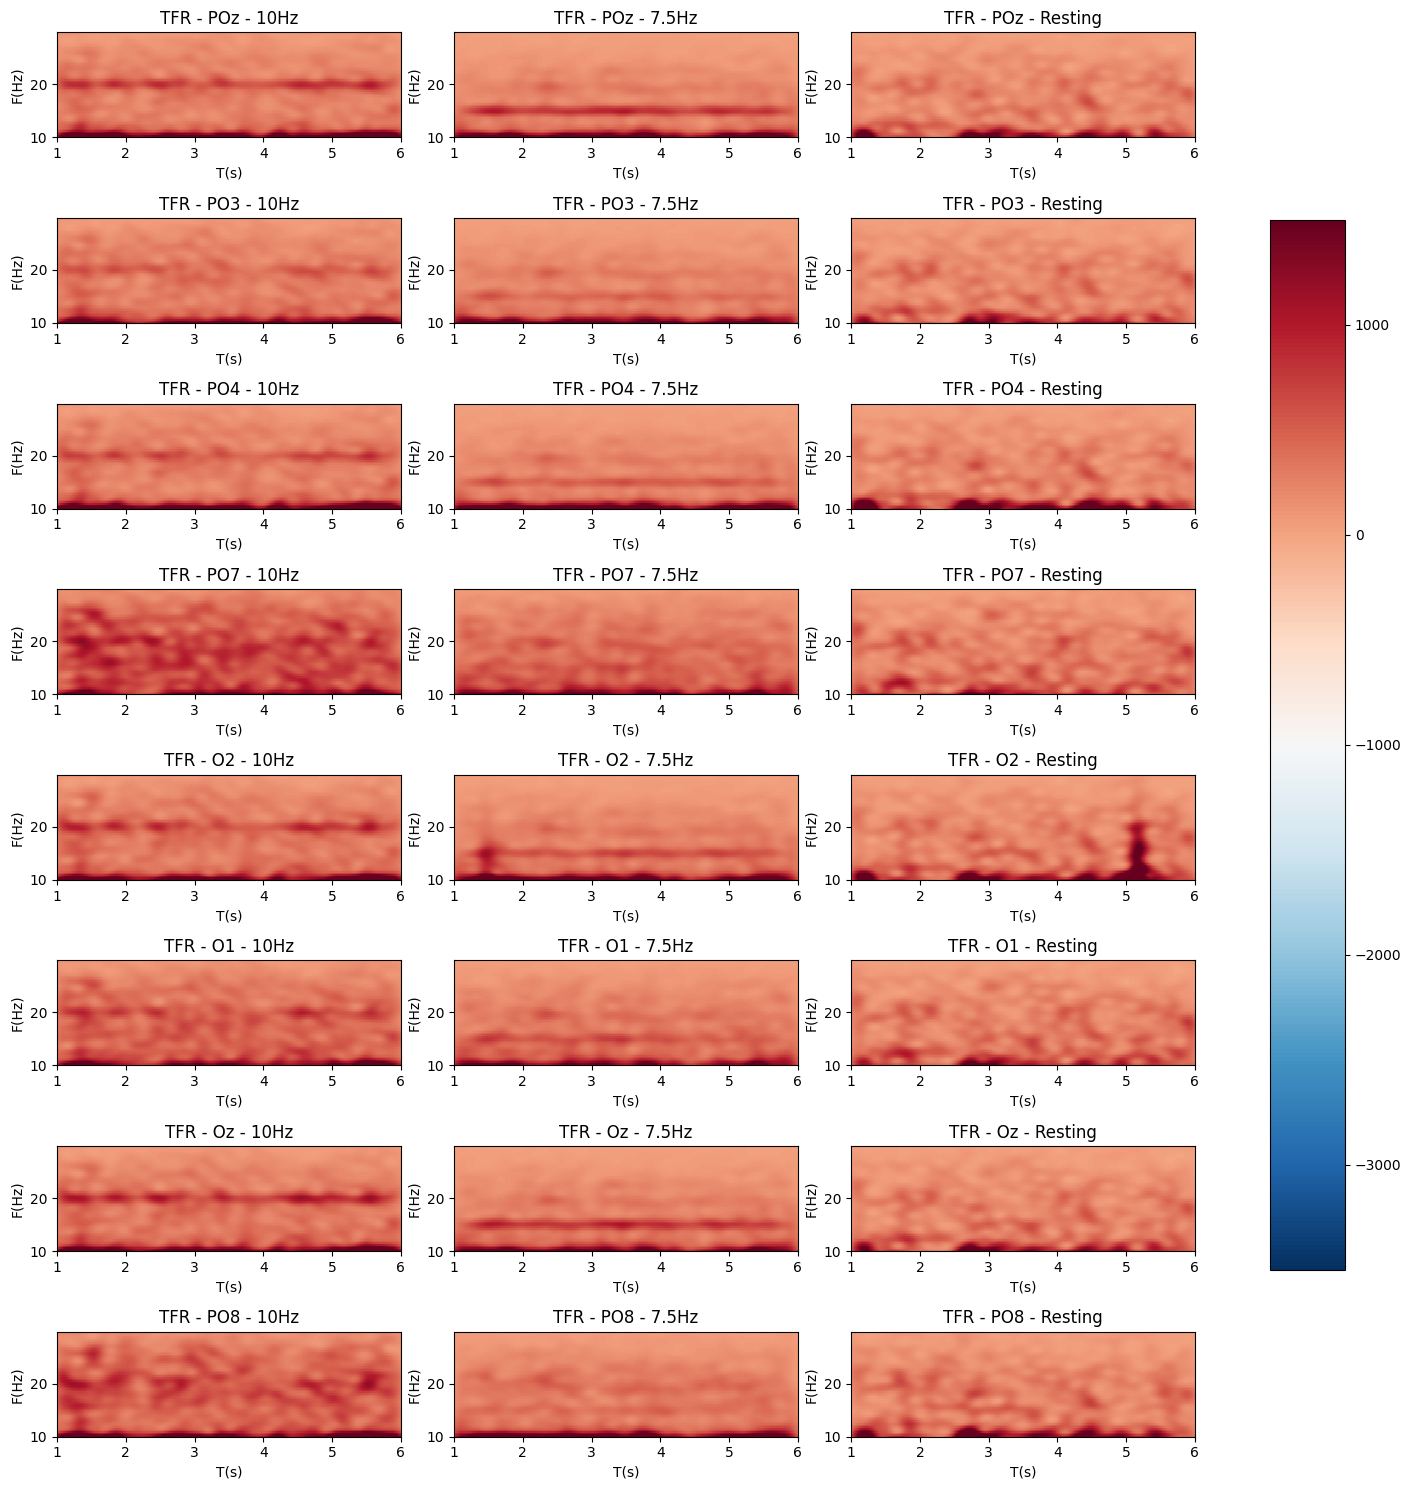

In [601]:
x, y = mne.viz.centers_to_edges(times, freqs)

fig, ax = plt.subplots(n_chan, len(class_names), figsize=(15, 15))
for j in range(len(class_names)):
    for i in range(n_chan):
        mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r', vmin=-3500, vmax=1500)
        ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
        ax[i, j].set(ylim=freqs[[0, -1]], xlabel='T(s)', ylabel='F(Hz)')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
plt.show()

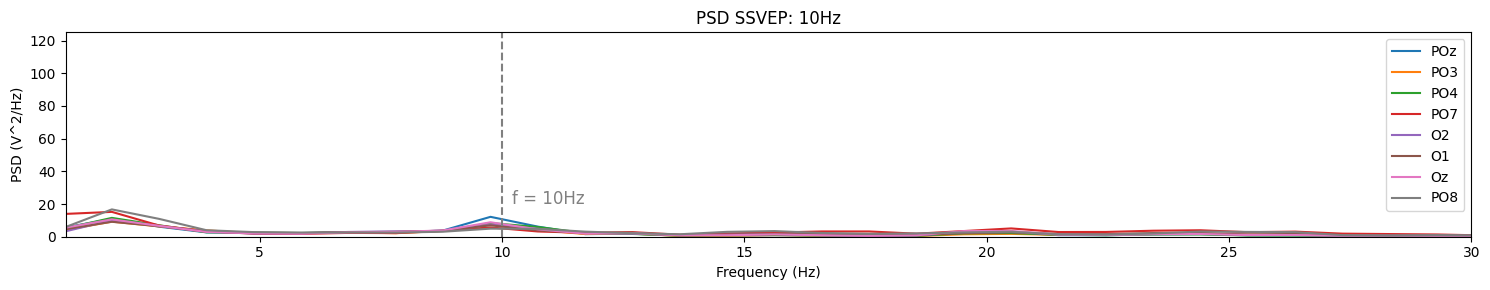

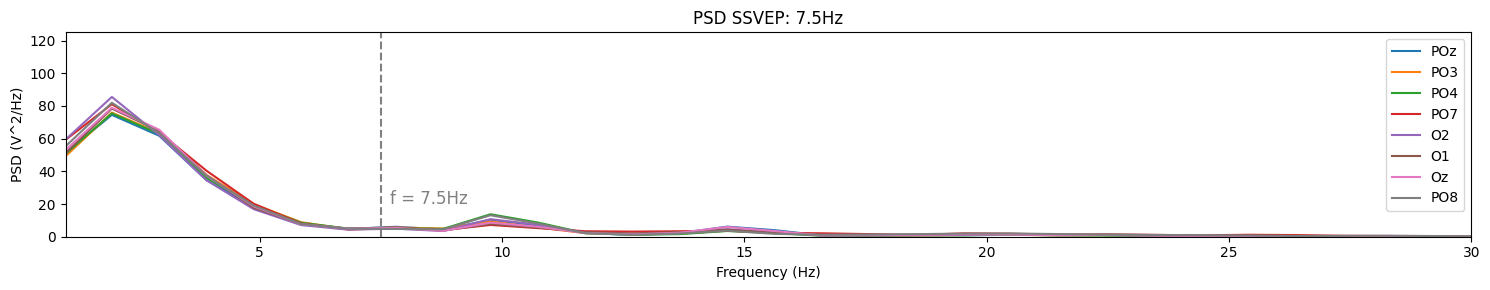

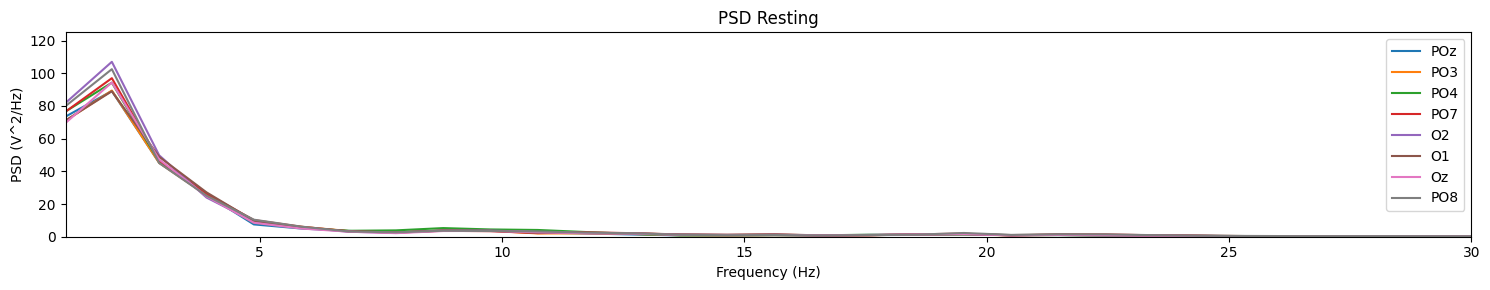

In [591]:
psd_plot(epochs_10[0],chan_name, title = "SSVEP: 10Hz", line=10)
psd_plot(epochs_7_5[3],chan_name,title = 'SSVEP: 7.5Hz',line=7.5)
psd_plot(epochs_resting[0],chan_name,title = 'Resting')